#**We employ the following models:**

1. CNN
2. LSTM
3. BiLSTM
4. GRU

#Hybrid
5. CNN-LSTM
6. CNN-BiLSTM
7. CNN-GRU


#**IMPORTS**

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector 
from tensorflow.keras.layers import TimeDistributed, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file = 'drive/MyDrive/Colab Notebooks/ja.csv'
#raw_data = pd.read_csv(file, parse_dates = ['date'], index_col = 'date')
raw_data = pd.read_csv(file)
df = raw_data.copy()
print(df.head())

         date  PM2dot5    PM10     NO    NO2    NOx    NH3    SO2    CO  \
0  01-02-2018   260.58  504.32  26.72  73.75  94.57  48.01  24.38  1.97   
1  02-02-2018   198.96  391.71  23.28  79.47  95.03  57.70  11.98  1.52   
2  03-02-2018   190.42  388.17  26.08  77.89  91.11  54.50  10.53  1.45   
3  04-02-2018   211.33  389.42  16.51  73.13  77.54  50.47  11.33  1.37   
4  05-02-2018   268.17  483.92  23.17  76.73  92.64  52.75  15.00  1.72   

   Ozone  Wind speed  
0    NaN        0.73  
1    NaN        0.77  
2    NaN        0.87  
3  13.32        0.95  
4  12.56        0.66  


In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)

In [5]:
missing_values = df.isnull().sum().sum()
if missing_values > 0:
    print(f'There are {missing_values} missing values in the data.')

There are 57 missing values in the data.


In [6]:
print(df.dtypes)

PM2dot5       float64
PM10          float64
NO            float64
NO2           float64
NOx           float64
NH3           float64
SO2           float64
CO            float64
Ozone         float64
Wind speed    float64
dtype: object


#**EDA & Preprocessing**

In [7]:
df.describe()

,PM2dot5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Wind speed
count,1822.000000,1818.000000,1823.000000,1823.000000,1823.000000,1819.000000,1816.000000,1820.000000,1817.000000,1822.000000
mean,132.756647,260.776392,32.471980,59.337186,63.391179,60.413793,13.926999,1.548456,26.774810,0.545483
std,105.115303,149.575060,28.326179,37.264376,47.310181,29.113144,8.734893,0.678047,18.786644,0.359911
min,8.770000,15.480000,1.700000,8.630000,9.750000,1.300000,0.380000,0.000000,1.600000,0.130000
25%,52.057500,135.085000,11.065000,32.190000,28.140000,38.235000,8.100000,1.050000,10.340000,0.330000
50%,97.855000,244.570000,22.420000,50.800000,48.030000,52.550000,11.885000,1.440000,22.760000,0.450000
75%,187.382500,356.727500,45.960000,72.935000,85.435000,81.360000,18.175000,1.880000,39.850000,0.680000
max,658.260000,928.870000,166.490000,237.590000,336.640000,205.680000,85.380000,6.150000,91.420000,6.330000


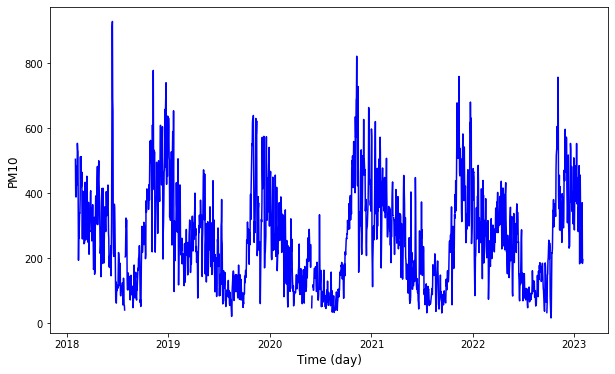

In [8]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})

timeseries(df.index, df['PM10'], 'Time (day)', 'PM10')


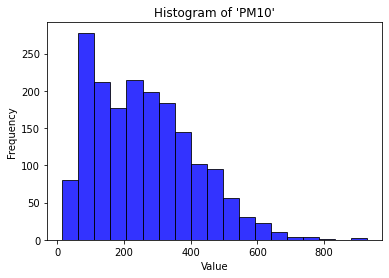

In [9]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'blue', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['PM10'])

In [10]:
#RENAME
#df = df.rename(columns = {'Max Temp (C)':'Max_T', 'Min Temp (C)':'Min_T','Total Precip (mm)':'T_P','WC (m3/capita.day)':'UWC'})

# Missing values
df.isnull().sum()

PM2dot5        4
PM10           8
NO             3
NO2            3
NOx            3
NH3            7
SO2           10
CO             6
Ozone          9
Wind speed     4
dtype: int64

In [11]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df['PM2dot5'])
replace_missing(df['PM10'])
replace_missing(df['NO'])
replace_missing(df['NO2'])
replace_missing(df['NOx'])
replace_missing(df['NH3'])
replace_missing(df['SO2'])
replace_missing(df['CO'])
replace_missing(df['Ozone'])
replace_missing(df['Wind speed'])

In [12]:
nan_df = df.isna()
nan_count = nan_df.sum()
nan_count

PM2dot5       0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
SO2           0
CO            0
Ozone         3
Wind speed    0
dtype: int64

In [13]:
df.fillna(26, inplace=True)

In [14]:
df = df.rename(columns = {'Wind speed':'wind'})

In [15]:
assert not np.any(np.isnan(df))
df.to_csv("janew.csv", index=False)

In [16]:
# Outlier detection
up_b = df['PM10'].mean() + 2*df['PM10'].std()
low_b = df['PM10'].mean() - 2*df['PM10'].std()

# Replace outlier by interpolation for base consumption
df.loc[df['PM10'] > up_b, 'PM10'] = np.nan
df.loc[df['PM10'] < low_b, 'PM10'] = np.nan
df['PM10'].interpolate(inplace=True)

## Train/validation split

Dimension of train data:  (1460, 10)
Dimension of test data:  (366, 10)


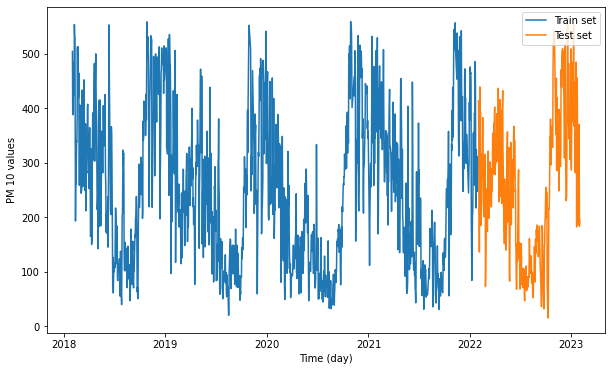

In [17]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.PM10)
plt.plot(test_dataset.PM10)
plt.xlabel('Time (day)')
plt.ylabel('PM 10 values')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [18]:
X_train = train_dataset.drop('PM10', axis = 1)
y_train = train_dataset.loc[:,['PM10']]

X_valid = test_dataset.drop('PM10', axis = 1)
y_valid = test_dataset.loc[:,['PM10']]

In [19]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
valid_y_norm = output_scaler.transform(y_valid)
valid_x_norm = input_scaler.transform(X_valid)

In [20]:
def create_dataset (X, Y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(Y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_valid, Y_valid = create_dataset(valid_x_norm, valid_y_norm, TIME_STEPS)
X_train, Y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_valid.shape)
print('Y_train.shape: ', Y_train.shape)
print('X_valid.shape: ', X_valid.shape) 
print('Y_valid.shape: ', Y_train.shape)

X_train.shape:  (336, 30, 9)
Y_train.shape:  (1430, 1)
X_valid.shape:  (336, 30, 9)
Y_valid.shape:  (1430, 1)


#**MODEL TRAINING**

In [21]:
epochs = 40
batch = 256
lr = 0.00003
adam = optimizers.RMSprop(lr)

In [22]:
X_train_series = X_train.reshape(1430,30,9)
X_valid_series = X_valid.reshape(336,30,9)
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1430, 30, 9)
Validation set shape (336, 30, 9)


#4. GRU

In [23]:
from tensorflow.keras.layers import Dense, Dropout, GRU 
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_gru.add(Dense(y_train.shape[1]))

model_gru.compile(loss='mse', optimizer='adam')

In [24]:
gru_history = model_gru.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
45/45 - 7s - loss: 0.0845 - val_loss: 0.0291 - 7s/epoch - 149ms/step
Epoch 2/40
45/45 - 2s - loss: 0.0285 - val_loss: 0.0227 - 2s/epoch - 34ms/step
Epoch 3/40
45/45 - 2s - loss: 0.0236 - val_loss: 0.0196 - 2s/epoch - 55ms/step
Epoch 4/40
45/45 - 2s - loss: 0.0218 - val_loss: 0.0183 - 2s/epoch - 44ms/step
Epoch 5/40
45/45 - 2s - loss: 0.0208 - val_loss: 0.0183 - 2s/epoch - 39ms/step
Epoch 6/40
45/45 - 2s - loss: 0.0198 - val_loss: 0.0165 - 2s/epoch - 39ms/step
Epoch 7/40
45/45 - 2s - loss: 0.0193 - val_loss: 0.0159 - 2s/epoch - 37ms/step
Epoch 8/40
45/45 - 2s - loss: 0.0186 - val_loss: 0.0158 - 2s/epoch - 38ms/step
Epoch 9/40
45/45 - 1s - loss: 0.0178 - val_loss: 0.0160 - 691ms/epoch - 15ms/step
Epoch 10/40
45/45 - 1s - loss: 0.0171 - val_loss: 0.0147 - 732ms/epoch - 16ms/step
Epoch 11/40
45/45 - 1s - loss: 0.0169 - val_loss: 0.0171 - 757ms/epoch - 17ms/step
Epoch 12/40
45/45 - 1s - loss: 0.0162 - val_loss: 0.0154 - 835ms/epoch - 19ms/step
Epoch 13/40
45/45 - 1s - loss: 0.016

##GRU on train and validation

In [25]:
gru_train_pred = model_gru.predict(X_train_series)
gru_valid_pred = model_gru.predict(X_valid_series)
print('Train')
print('MAE:', mean_absolute_error(Y_train, gru_train_pred))
print('MSE:', mean_squared_error(Y_train, gru_train_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_train, gru_train_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_train, gru_train_pred))
print('R-squared', r2_score(Y_train, gru_train_pred))

print('Validation')
print('MAE:', mean_absolute_error(Y_valid, gru_valid_pred))
print('MSE:', mean_squared_error(Y_valid, gru_valid_pred))
print('RMSE:', np.sqrt(mean_squared_error(Y_valid, gru_valid_pred)))
print('MAPE:', mean_absolute_percentage_error(Y_valid, gru_valid_pred))
print('R-squared', r2_score(Y_valid, gru_valid_pred))

11/11 [==============================] - 0s 7ms/step
Train
MAE: 0.08450612811917603
MSE: 0.012682596927012655
RMSE: 0.11261703657534528
MAPE: 161451654778.7551
R-squared 0.800919918149882
Validation
MAE: 0.09600812728418691
MSE: 0.014065741527022715
RMSE: 0.11859907894677224
MAPE: 0.37853851568901964
R-squared 0.7692973450856544


# **TRUE VS PREDICTION**

## GRU true future vs prediction

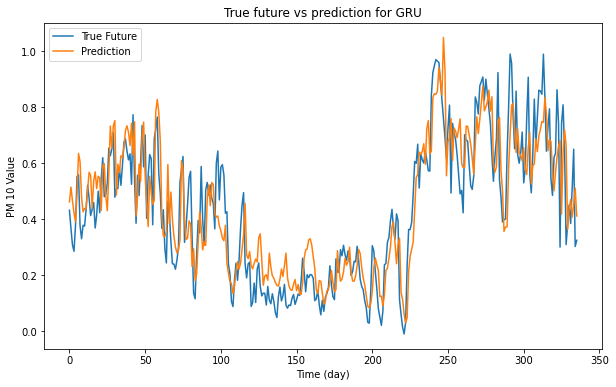

In [26]:
def plot_future(Y_valid):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(gru_valid_pred)

    plt.plot(np.arange(range_future), np.array(Y_valid), label='True Future')
    plt.plot(np.arange(range_future), np.array(gru_valid_pred),label='Prediction')

    plt.title('True future vs prediction for ' + "GRU")
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')

plot_future(Y_valid)

#**FORECASTING**

In [27]:
# Import climate data projection
newinput = pd.read_csv('drive/MyDrive/Colab Notebooks/check.csv', parse_dates=['date'], index_col = 'date')

# Order of the variable are important
X_new = newinput.loc['2020-01-01':'2020-11-01',:] 
X_new = X_new.rename(columns = {'Wind speed':'wind'})
X_new

,PM2dot5,NO,NO2,NOx,NH3,SO2,CO,Ozone,wind
date,,,,,,,,,
2020-01-01,463.70,138.69,187.54,221.16,84.05,8.03,3.01,4.45,0.38
2020-01-02,468.71,154.67,175.03,242.23,94.45,9.94,3.56,3.38,0.22
2020-01-03,442.17,132.56,182.31,254.12,97.50,9.48,2.89,4.36,0.38
2020-01-04,465.35,114.51,192.79,239.20,89.46,7.36,2.53,3.59,0.28
2020-01-05,360.12,74.52,179.69,156.32,79.28,NaN,1.74,2.82,0.35
...,...,...,...,...,...,...,...,...,...
2020-10-28,491.30,76.29,93.24,112.38,29.82,14.84,1.83,59.50,0.20
2020-10-29,564.98,88.86,108.13,161.25,37.01,9.73,2.19,28.58,0.14
2020-10-30,512.80,54.78,78.04,86.17,29.58,4.14,1.63,2.02,0.27


In [28]:
# Plot histoy and future data
def plot_history_future(Y_train, model):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(Y_train)
    range_future = list(range(range_history, range_history + len(model)))

    plt.plot(np.arange(range_history), np.array(Y_train), label='History')
    plt.plot(range_future, np.array(model),label='Prediction')

    plt.title('History and prediction for the best performing model')
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/3.jpg', format='jpg', dpi=1000)

In [29]:
def forecast(X_input, time_steps, model_name):
    X = input_scaler.transform(X_input)
    X = X_input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)
    prediction_actual = model_name.predict(X_transformed)
    return prediction_actual

# GRU Forecast

9/9 [==============================] - 0s 5ms/step


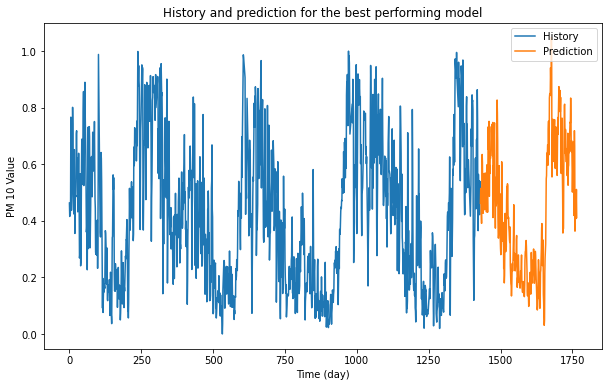

In [30]:
prediction_actual = forecast(X_new, TIME_STEPS, model_gru)
plot_history_future(Y_train, gru_valid_pred)

In [31]:
import joblib
#joblib.dump(model_gru, 'finalized_model.sav')
joblib.dump(model_gru, 'gru.joblib')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......gru
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-03-03 17:05:29       130080
metadata.json                                  2023-03-03 17:05:29           64
config.json                                    2023-03-03 17:05:29         1780


['gru.joblib']

In [32]:
model_gru.save('grumodel.h5')
print('Model Saved!')

Model Saved!
